# 08. PyTorch Paper Replicating

## 0. Get setup

In [1]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 39.30 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get data

In [3]:
data_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
data_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

## 2. Create Datasets and DataLoaders

In [4]:
import os

train_dir = data_path / "train"
test_dir = data_path / "test"

IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

transform = transforms.Compose([
    transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()

])



train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                              test_dir=test_dir,
                                                                              transform=transform,
                                                                              batch_size=BATCH_SIZE,
                                                                              num_workers=NUM_WORKERS)
len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image

In [5]:
images, labels = next(iter(train_dataloader))
images.shape, labels

(torch.Size([32, 3, 224, 224]),
 tensor([2, 2, 1, 1, 1, 1, 0, 0, 1, 2, 1, 1, 0, 2, 0, 2, 1, 0, 0, 2, 0, 0, 0, 1,
         2, 2, 2, 1, 1, 2, 2, 2]))

In [6]:
image, label = images[0], labels[0]

(-0.5, 223.5, 223.5, -0.5)

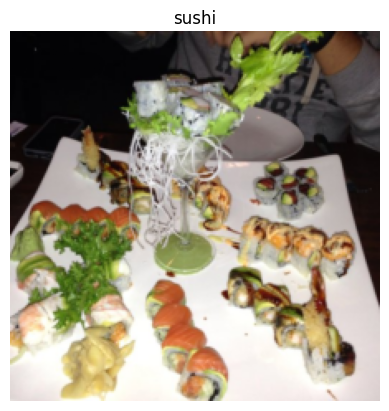

In [7]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis("off")

## 3. Replicating ViT

## 4. Equation 1: Split data into patches and creating the class, position and path embedding

* Input shape: $H\times{W}\times{C}$
* Output shape: ${N \times\left(P^{2} \cdot C\right)}$

* H = height
* W = width
* C = color channels
* P = patch size
* N = number of paches = (height * width) / p^2
* D = constant latent vector size = embedding dimension

### 4.1 Calculate input and output shapes by hand

In [8]:
# Create example values
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate the number of patches
number_of_patches = int((height * width) / (patch_size ** 2))
number_of_patches

196

In [9]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)
print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768)


### 4.2 Turning a single image into patches

(-0.5, 223.5, 223.5, -0.5)

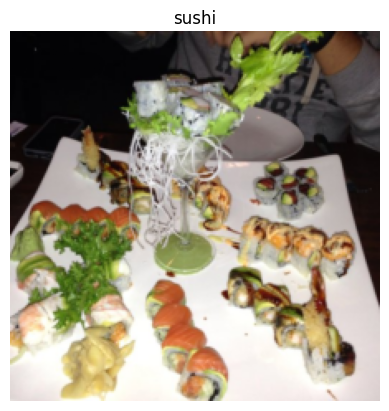

In [10]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis("off")

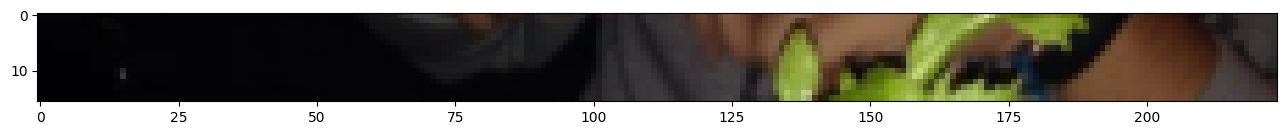

In [11]:
# Get the top row of the image
image_permuted = image.permute(1, 2, 0)
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

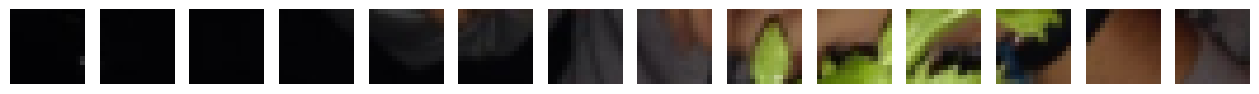

In [12]:
# Setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
fig, axis = plt.subplots(nrows=1,
                         ncols=img_size // patch_size,
                         sharex=True,
                         sharey=True, figsize=(patch_size, patch_size))
for i, patch in enumerate(range(0, img_size, patch_size)):
  axis[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
  axis[i].set_xlabel(i+1)
  axis[i].set_xticks([])
  axis[i].set_yticks([])
  axis[i].axis("off")

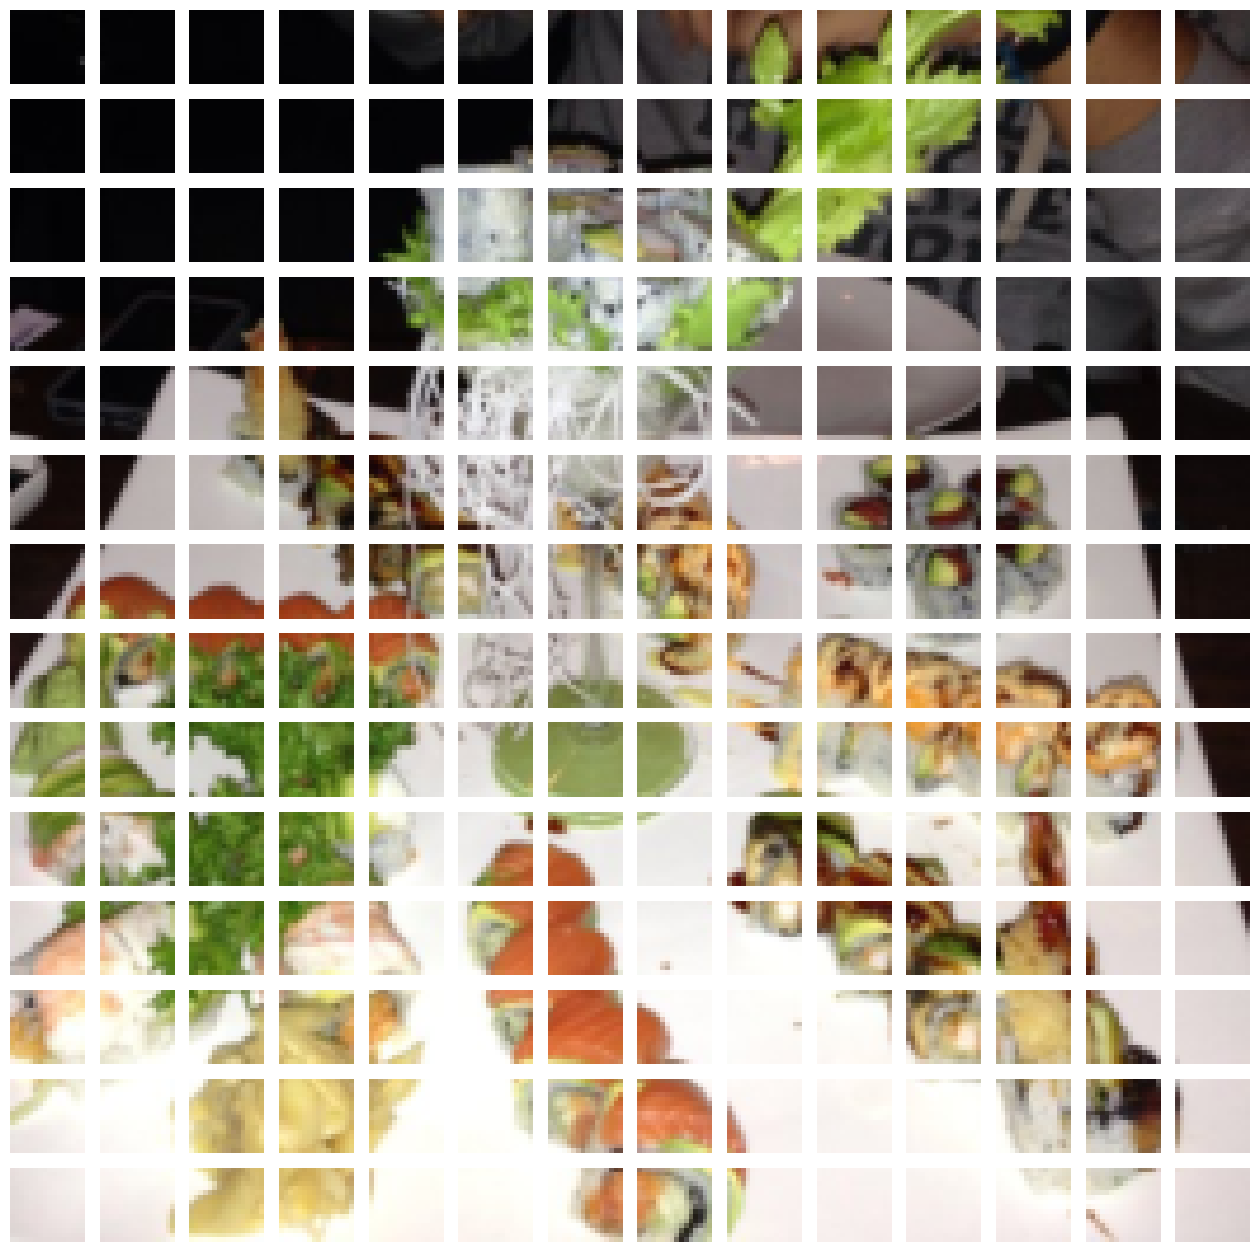

In [13]:
 # Setup code to plot whole image as patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"

fig, axis = plt.subplots(nrows=img_size // patch_size,
                         ncols=img_size // patch_size,
                         sharex=True,
                         sharey=True, figsize=(patch_size, patch_size))

for i, patch_row in enumerate(range(0, img_size, patch_size)):
  for j, patch_col in enumerate(range(0, img_size, patch_size)):
    axis[i][j].imshow(image_permuted[patch_row:patch_row + patch_size, patch_col:patch_col+patch_size, :])
    axis[i][j].set_xlabel(i+1)
    axis[i][j].set_xticks([])
    axis[i][j].set_yticks([])
    axis[i][j].axis("off")

### 4.3 Creating image patches and turning them into patch embeddings

In [14]:
# Create conv2ddd layer to turn image into patches of learnable feature maps (embedings)
from torch import nn

patch_size = 16
conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(-0.5, 223.5, 223.5, -0.5)

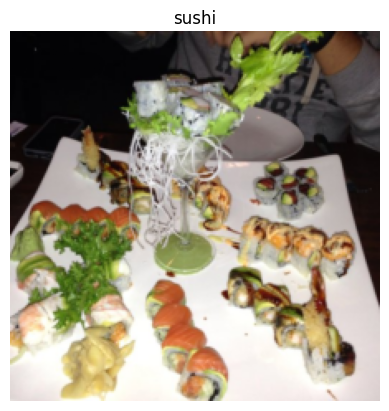

In [15]:
# View single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [16]:
# pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(dim=0))
image_out_of_conv.shape

torch.Size([1, 768, 14, 14])

Random indexs: [392, 217, 567, 627, 146]


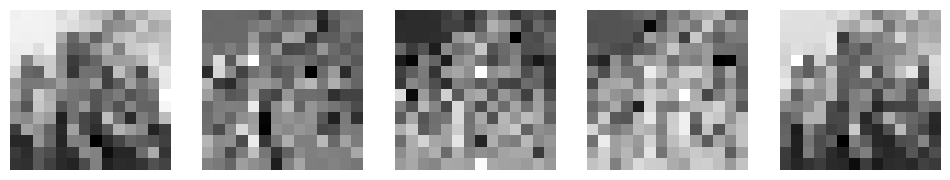

In [17]:
# plot random convolutionla feature maps (embeddings)

import random
random_indexs = random.sample(range(0, 758), k=5)
print(f"Random indexs: {random_indexs}")

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))
for i, idx in enumerate(random_indexs):
  image_conv_feature_map = image_out_of_conv[:, idx, :, :]
  axs[i].imshow(image_conv_feature_map.detach().numpy().squeeze(), cmap=plt.cm.gray)
  axs[i].axis("off")


In [18]:
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map

tensor([[[0.0554, 0.0466, 0.0477, 0.0501, 0.0744, 0.0612, 0.1397, 0.1881,
          0.2193, 0.2015, 0.4025, 0.0547, 0.2717, 0.2537],
         [0.0441, 0.0457, 0.0465, 0.0486, 0.0593, 0.2579, 0.2482, 0.2438,
          0.0936, 0.2705, 0.3003, 0.1778, 0.2785, 0.2960],
         [0.0497, 0.0514, 0.0536, 0.0555, 0.1498, 0.6713, 0.4119, 0.4694,
          0.3483, 0.3430, 0.2567, 0.2362, 0.2422, 0.3104],
         [0.1665, 0.0506, 0.0338, 0.1409, 0.0644, 0.4086, 0.7734, 0.5812,
          0.3987, 0.4593, 0.4617, 0.2397, 0.1859, 0.2219],
         [0.1377, 0.2865, 0.5452, 0.3835, 0.3329, 0.7469, 0.7340, 0.7257,
          0.5381, 0.4762, 0.4291, 0.3066, 0.3381, 0.0701],
         [0.0892, 0.4877, 0.6298, 0.4160, 0.3163, 0.7115, 0.6069, 0.5483,
          0.6943, 0.4744, 0.1311, 0.3605, 0.4431, 0.0685],
         [0.3726, 0.5666, 0.6300, 0.4203, 0.4570, 0.6458, 0.6473, 0.4027,
          0.5807, 0.6722, 0.3993, 0.6439, 0.5824, 0.0915],
         [0.2955, 0.4472, 0.1852, 0.1785, 0.2931, 0.7107, 0.5673, 0.6

### 4.4 Flattening the patch embedding with torch.nn.Flatten()

In [19]:
flatten_layer = nn.Flatten(start_dim=2, end_dim=-1)
image_out_of_flat = flatten_layer(image_out_of_conv)
image_out_of_flat.permute(0, 2, 1).shape

torch.Size([1, 196, 768])

In [20]:
single_flattened_feature_map = image_out_of_flat.permute(0, 2, 1)[:, :, 0]

# Plot the flattenend feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.axis("off")

(-0.5, 195.5, 0.5, -0.5)

### 4.5 Turning the ViT patch embedding layer into a PyTorch module

In [21]:
input_layer = nn.Sequential(
    nn.Conv2d(in_channels=3,
              out_channels=768,
              kernel_size=patch_size,
              stride=patch_size,
              padding=0),

    nn.Flatten(start_dim=2, end_dim=-1)
)

In [22]:
out_image = input_layer(image.unsqueeze(dim=0))
out_image.permute(0, 2, 1).shape

torch.Size([1, 196, 768])

In [23]:
class PatchEmbedding(nn.Module):
  def __init__(self,
               in_channels: int=3,
               patch_size:int=16,
               embedding_dim:int=768):
    super().__init__()
    self.patch_size = patch_size
    self.patcher = nn.Conv2d(in_channels=in_channels,
                            out_channels=embedding_dim,
                            kernel_size=patch_size,
                            stride=patch_size,
                            padding=0)
    self.flatten = nn.Flatten(start_dim=2, end_dim=3)

  def forward(self, x):
    image_resolution = x.shape[-1]
    assert image_resolution % self.patch_size == 0, "Image size must be divisible by patch size"
    x = self.patcher(x)
    x = self.flatten(x)
    return x.permute(0, 2, 1)

In [24]:
set_seeds()
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)
patch_embedded_image = patchify(image.unsqueeze(dim=0))
patch_embedded_image.shape, image.unsqueeze(dim=0).shape

(torch.Size([1, 196, 768]), torch.Size([1, 3, 224, 224]))

### 4.6 Creatign the class token embedding

In [25]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dim = patch_embedded_image.shape[-1]
batch_size, embedding_dim

(1, 768)

In [26]:
# Create class token embedding as a learnable parameter
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dim),
                           requires_grad=True)
class_token.shape

torch.Size([1, 1, 768])

In [27]:
# Add the class token embeding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1)
patch_embedded_image_with_class_embedding.shape, patch_embedded_image_with_class_embedding

(torch.Size([1, 197, 768]),
 tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.0400, -0.0037, -0.0312,  ...,  0.0203, -0.0062,  0.0199],
          [-0.0341, -0.0086, -0.0352,  ...,  0.0210, -0.0081,  0.0093],
          ...,
          [-1.0180,  0.1980, -0.2861,  ...,  0.7421, -0.4466,  0.3506],
          [-0.9913,  0.2703, -0.2092,  ...,  0.6873, -0.4294,  0.3077],
          [-0.8795,  0.2191, -0.2422,  ...,  0.6615, -0.4152,  0.3278]]],
        grad_fn=<CatBackward0>))

### 4.7 Creating the positionn embedding

In [28]:
number_of_patches = int((height * width)/ patch_size**2)
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]
position_embedding = nn.Parameter(torch.ones(batch_size, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)
position_embedding.shape

torch.Size([1, 197, 768])

In [29]:
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
patch_and_position_embedding.shape, patch_and_position_embedding

(torch.Size([1, 197, 768]),
 tensor([[[ 2.0000,  2.0000,  2.0000,  ...,  2.0000,  2.0000,  2.0000],
          [ 0.9600,  0.9963,  0.9688,  ...,  1.0203,  0.9938,  1.0199],
          [ 0.9659,  0.9914,  0.9648,  ...,  1.0210,  0.9919,  1.0093],
          ...,
          [-0.0180,  1.1980,  0.7139,  ...,  1.7421,  0.5534,  1.3506],
          [ 0.0087,  1.2703,  0.7908,  ...,  1.6873,  0.5706,  1.3077],
          [ 0.1205,  1.2191,  0.7578,  ...,  1.6615,  0.5848,  1.3278]]],
        grad_fn=<AddBackward0>))

### 4.8 Putting it all Together: from image to embedding

In [30]:
set_seeds()
patch_size = 16
patcher = PatchEmbedding(patch_size=patch_size,
                         in_channels=3,
                         embedding_dim=768,
                         )

patch_embedded_image = patcher(image.unsqueeze(dim=0))
print(patch_embedded_image.shape)

embedding_dim = patch_embedded_image.shape[-1]
batch_size = patch_embedded_image.shape[0]
number_of_patches = patch_embedded_image.shape[1]

class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dim))
position_embedding = nn.Parameter(torch.randn(batch_size, number_of_patches+1, embedding_dim))

patch_embedded_class_token = torch.cat((class_token, patch_embedded_image), dim=1)
print(patch_embedded_class_token.shape)
patch_and_position_embedding = patch_embedded_class_token + position_embedding
print(patch_and_position_embedding.shape)
patch_and_position_embedding

torch.Size([1, 196, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])


tensor([[[-4.8279e-01, -2.9331e+00, -1.0430e+00,  ..., -3.1039e-01,
           1.8254e+00,  7.0189e-01],
         [-7.3498e-01,  7.1515e-01, -1.1721e+00,  ..., -2.9498e-01,
          -2.2284e+00, -6.7231e-01],
         [-1.6195e+00, -3.2625e-01, -1.4363e+00,  ...,  1.8193e+00,
           4.9967e-01,  4.0765e-02],
         ...,
         [ 2.6750e-01,  1.0283e+00, -1.3643e-01,  ...,  2.6700e-01,
           8.1983e-01,  1.0264e+00],
         [-1.0320e+00, -2.4674e-01, -5.5802e-01,  ...,  1.9515e-01,
          -7.9148e-02,  1.6548e+00],
         [-1.1249e+00,  2.1440e-01,  1.2562e+00,  ...,  2.5398e-01,
           1.1633e+00, -2.6876e-04]]], grad_fn=<AddBackward0>)

## Equation 2: Multihead Self-Attention (MSA block)

In [31]:
class MultiHeadSelfAttentionBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               num_heads:int=12,
               attn_dropout:int=0):
    super().__init__()
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
    self.multihead_attention = nn.MultiheadAttention(embedd_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     dropout=attn_dropout,
                                                     batch_first=True)
    def forward(self, x):
      layer_norm_output = self.layer_norm(x)
      attention_output, _ = self.multihead_attention(query=layer_norm_output,
                                                     key=layer_norm_output,
                                                     value=layer_norm_output,
                                                     need_weights=False)

      return attention_output
